# Malicious URLs Detection

## Author

Thanks to the author of the following notebook for providing the dataset and the initial code: [Hamza Manssor](https://www.kaggle.com/code/hamzamanssor/detection-malicious-url-using-ml-models)

## Introduction

In this notebook, we will build a machine learning model to detect malicious URLs. We will use a dataset that contains URLs and their corresponding labels (benign or malicious). We will use the dataset to train a machine learning model that can predict whether a given URL is malicious or not.

## Dataset

The dataset we will use in this notebook is available at the following link: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data
It is necesary to download the dataset and upload it into the **data** folder in order to run this notebook.

In [55]:
pip install tld numpy pandas matplotlib seaborn colorama scikit-learn

Note: you may need to restart the kernel to use updated packages.


1. Libraries

In [56]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import LabelEncoder
from tld import get_tld, is_tld

2. Dataset

In [57]:
data = pd.read_csv('../data/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


3. Dataframe

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


4. NaN Values

In [59]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [60]:
count = data.type.value_counts()
count

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

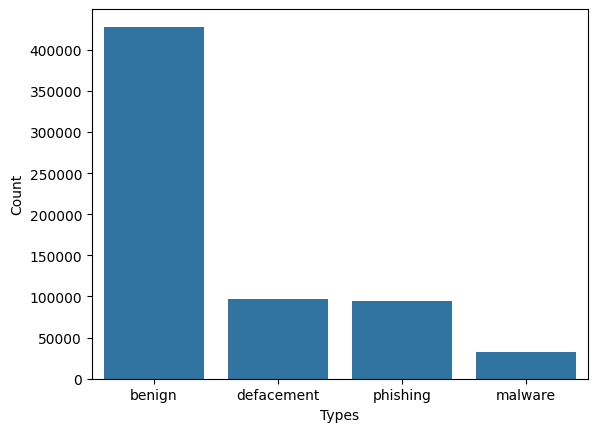

In [61]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [62]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [63]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [64]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

/var/folders/8c/2pprzh1d3vg1fhvmdl76x5w40000gn/T/ipykernel_42485/1624019599.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


5. Feature extraction

In [65]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [66]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [67]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [68]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [69]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [70]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [71]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [72]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

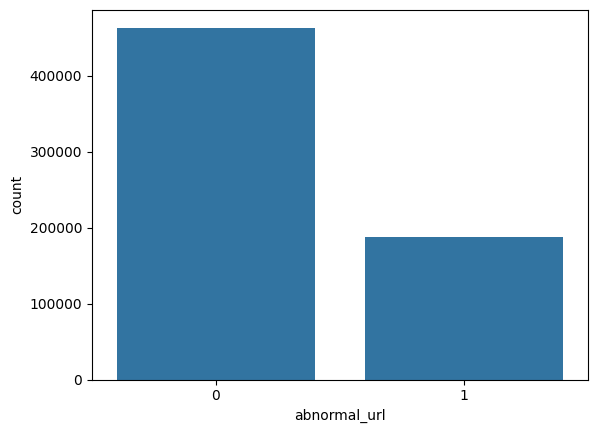

In [73]:
sns.countplot(x='abnormal_url', data=data);

In [74]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [75]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

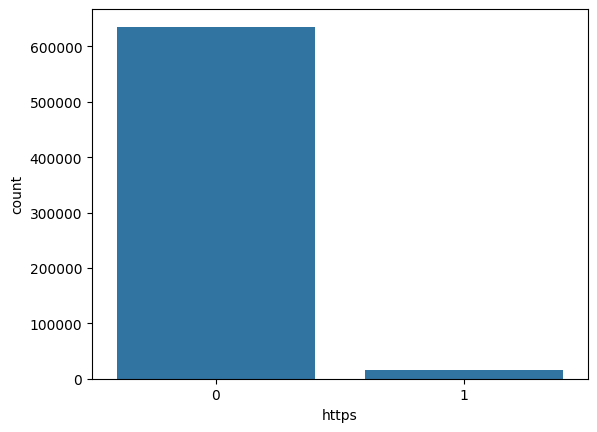

In [76]:
sns.countplot(x='https', data=data);

In [77]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [78]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [79]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [80]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [81]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [82]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

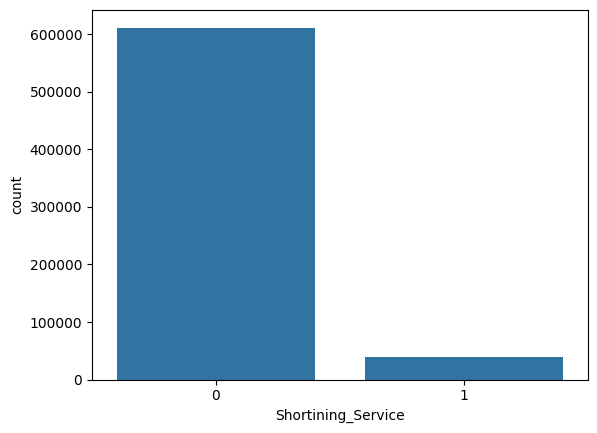

In [83]:
sns.countplot(x='Shortining_Service', data=data);

In [84]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [85]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [86]:
data['having_ip_address'].value_counts()

having_ip_address
0    638703
1     12488
Name: count, dtype: int64

<Axes: >

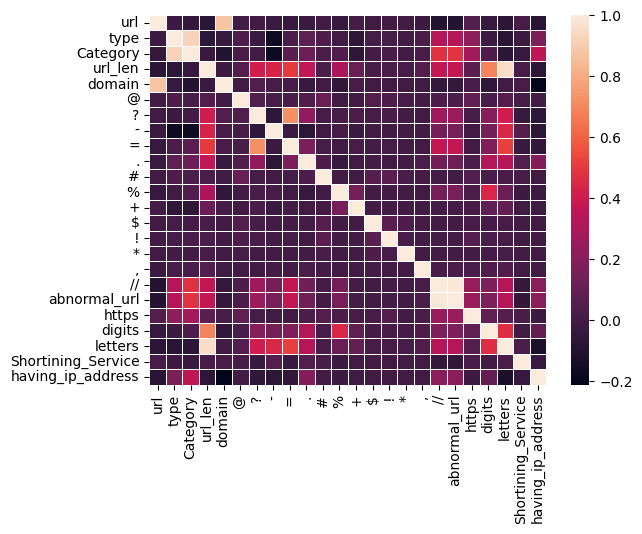

In [87]:
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in data.columns:
    # Check if the column contains string values
    if data[column].dtype == 'object':
        # Use label encoder to convert string values to numerical values
        data[column] = label_encoder.fit_transform(data[column].astype(str))
sns.heatmap(data.corr(), linewidths=.5)

In [88]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

6. Train and Test Split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  90.95%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.93      0.96      0.95     19319
           2       0.81      0.57      0.66     18805
           3       0.94      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

             Confusion_matrix 


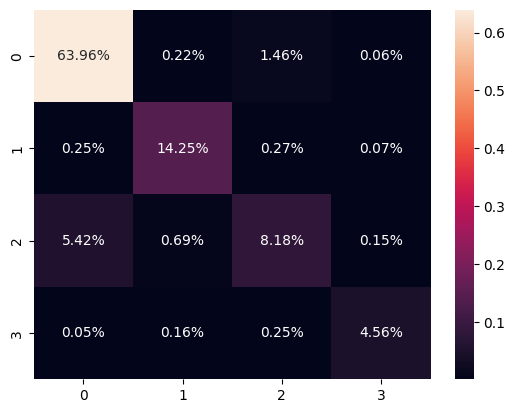

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.50%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.58      0.68     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.92    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.92      0.91    130239

             Confusion_matrix 


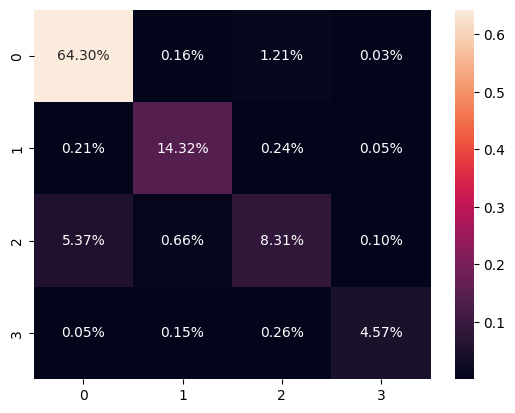

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 


/Users/marioteran/Documents/GitHub/LinkWarden/.conda/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy :  82.01%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     85565
           1       0.82      0.89      0.85     19319
           2       0.45      0.15      0.22     18805
           3       0.91      0.46      0.61      6550

    accuracy                           0.82    130239
   macro avg       0.75      0.62      0.65    130239
weighted avg       0.78      0.82      0.78    130239

             Confusion_matrix 


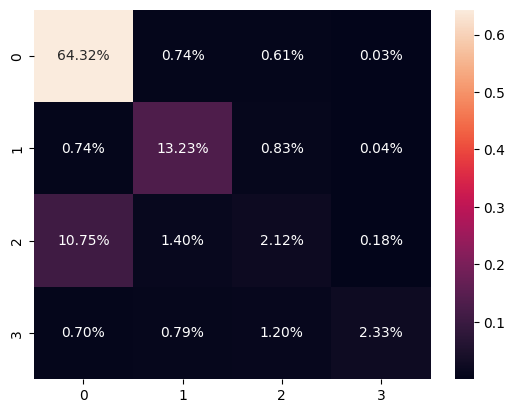

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  89.04%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     85565
           1       0.89      0.95      0.92     19319
           2       0.74      0.52      0.61     18805
           3       0.94      0.87      0.91      6550

    accuracy                           0.89    130239
   macro avg       0.87      0.83      0.84    130239
weighted avg       0.88      0.89      0.88    130239

             Confusion_matrix 


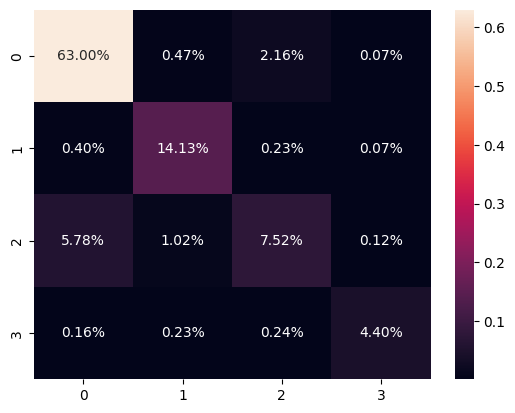

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  81.04%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     85565
           1       0.80      0.91      0.85     19319
           2       0.76      0.01      0.02     18805
           3       0.50      0.80      0.62      6550

    accuracy                           0.81    130239
   macro avg       0.73      0.67      0.60    130239
weighted avg       0.81      0.81      0.75    130239

             Confusion_matrix 


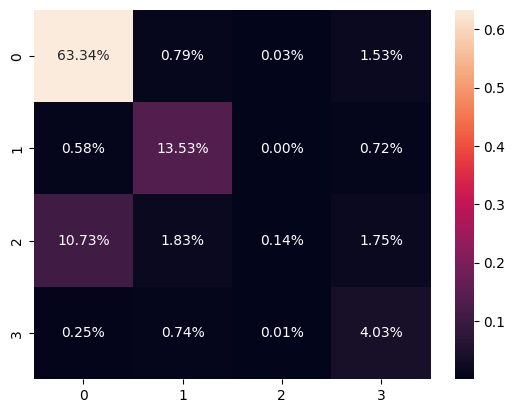

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  91.47%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.93      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.97      0.91      0.94      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


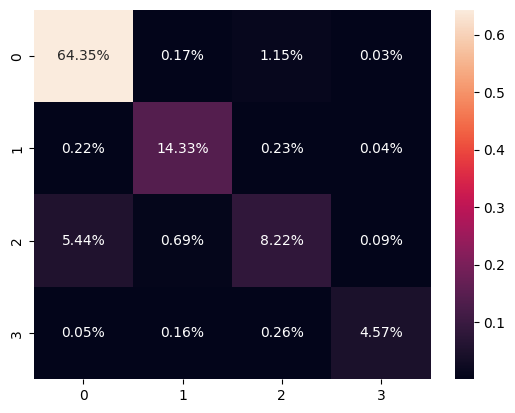

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  78.95%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.66      1.00      0.79     19319
           2       0.60      0.02      0.04     18805
           3       0.61      0.70      0.65      6550

    accuracy                           0.79    130239
   macro avg       0.68      0.66      0.59    130239
weighted avg       0.77      0.79      0.74    130239

             Confusion_matrix 


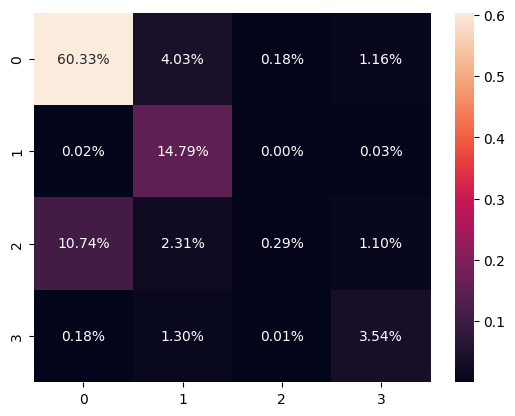

###################- End -###################


In [91]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

7. Final Report

In [92]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

In [94]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.909505
1,Random Forest Classifier,0.915002
2,AdaBoost Classifier,0.820062
3,KNeighbors Classifier,0.890409
4,SGD Classifier,0.810418
5,Extra Trees Classifier,0.914711
6,Gaussian NB,0.789548


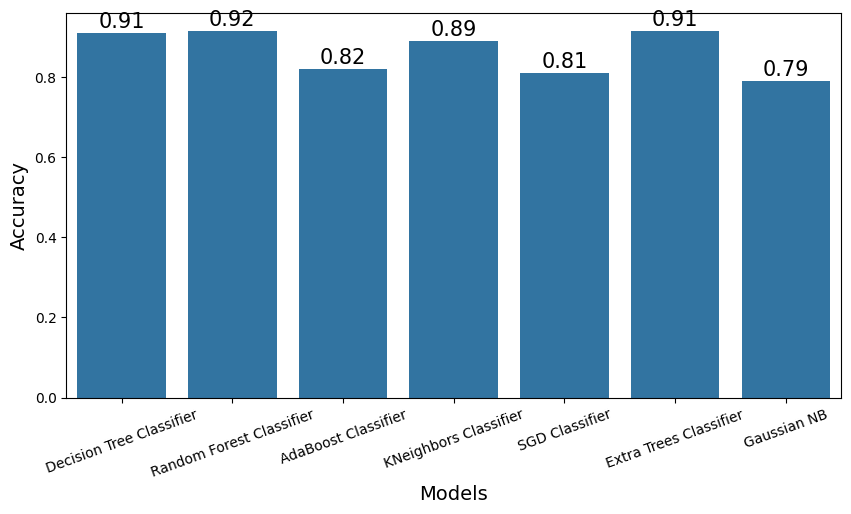

In [95]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()